# Generative Adversarial Networks (GANs)

based on
https://keras.io/examples/generative/conditional_gan/

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from keras import layers
from keras import ops
import tensorflow as tf
import numpy as np
import imageio

!pip install -q git+https://github.com/tensorflow/docs
from tensorflow_docs.vis import embed

import tensorflow as tf
print("TF Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



TF Num GPUs Available:  1


In [5]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128


In [6]:
# We'll use all the available examples from both the training and test sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")


Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [7]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [8]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


In [9]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [10]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)


Epoch 1/20


I0000 00:00:1763984056.673919   49862 service.cc:145] XLA service 0x79ffe00032c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763984056.674020   49862 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-11-24 12:34:16.740626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-24 12:34:17.048865: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   5/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - d_loss: 0.6733 - g_loss: 0.8044

I0000 00:00:1763984062.862359   49862 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - d_loss: 0.4043 - g_loss: 1.6009
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 0.4318 - g_loss: 1.5396
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 0.3488 - g_loss: 1.8160
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - d_loss: 0.3403 - g_loss: 1.8753
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - d_loss: 0.5759 - g_loss: 1.2366
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - d_loss: 0.6476 - g_loss: 0.9555
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - d_loss: 0.6496 - g_loss: 0.9045
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - d_loss: 0.6627 - g_loss: 0.8573
Epoch 9/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - d_loss: 0.6671 - g_loss: 0.8282
Epoch 10/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - d_loss: 0.6761 - g_loss: 0.7983
Epoch 11/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - d_loss: 0.6739 - g_loss: 0.7856
Epoch 12/20
1094/10

In [26]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 2  # @param {type:"slider", min:0, max:9, step:1}
end_class = 6  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



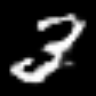

In [27]:
fake_images_255 = fake_images*255.0
converted_images = fake_images_255.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")
